## Importowanie pakietów

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import math
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap
from collections import defaultdict
from sklearn.metrics import completeness_score, homogeneity_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score

## Definicja sieci

In [184]:
class KohonenNetwork:
    def __init__(self, M, N, input_dim, initial_sigma=1.0, sigma_decay=1.0, init_lr=0.1, decay_rate=100, neighborhood_function='gaussian'):
        # Inicjalizacja sieci z podanymi parametrami oraz przygotowanie wag i mapy klastrów.
        self.M, self.N, self.input_dim = M, N, input_dim
        self.initial_sigma, self.sigma_decay = initial_sigma, sigma_decay
        self.init_lr, self.decay_rate = init_lr, decay_rate
        self.weights = np.random.rand(M, N, input_dim)
        self.bmu_cluster_map = np.zeros((M, N), dtype=int)
        self.neighborhood_function = neighborhood_function

    def train(self, input_data, num_epochs):
        # Proces uczenia sieci przez określoną liczbę epok.
        for epoch in range(num_epochs):
            sigma = self.initial_sigma * np.exp(-epoch / self.decay_rate) * self.sigma_decay
            learning_rate = self.init_lr * np.exp(-epoch / self.decay_rate)
            
            for data_sample in input_data:
                # Znajdź BMU i zaktualizuj wagi
                self._find_bmu_and_update_weights(data_sample, sigma, learning_rate)


    def _neighborhood_function(self, distance, sigma):
        # Funkcja sąsiedztwa, która oblicza wpływ odległości na aktualizację wag.
        if self.neighborhood_function == 'gaussian':
            return np.exp(-distance**2 / (2 * sigma**2))
        elif self.neighborhood_function == 'mexican_hat':
            return (1 - (distance**2 / sigma**2)) * np.exp(-distance**2 / (2 * sigma**2))
        else:
            raise ValueError(f"Nieznana funkcja sąsiedztwa: {self.neighborhood_function}")



    def _find_bmu_and_update_weights(self, sample, sigma, lr):
        # Znalezienie BMU, aktualizacja wag i zwrócenie BMU.
        distances = np.linalg.norm(self.weights - sample, axis=2)
        bmu = np.unravel_index(np.argmin(distances), distances.shape)
        
        if sigma and lr:
            x, y = np.ogrid[0:self.M, 0:self.N]
            distance = np.sqrt((x - bmu[0])**2 + (y - bmu[1])**2)
            influence = self._neighborhood_function(distance, sigma)
            self.weights += lr * influence[..., np.newaxis] * (sample - self.weights)
        
        return bmu

    
    def assign_clusters(self, input_data):
        # Mapowanie klastrów na podstawie danych wejściowych.
        cluster_stats = defaultdict(list)

        for i, data_sample in enumerate(input_data):
            # Wyszukujemy BMU, przy czym nie aktualizujemy wag
            best_matching_unit = self._find_bmu_and_update_weights(data_sample, None, None)
            self.bmu_cluster_map[best_matching_unit] = i



    def display_clustered_data(self, input_data, neuron_positions=True, view_data=True, vscore=None, ax=None):
        # Wizualizacja sklastrowanych danych wejściowych.
        assigned_clusters = np.array([self.bmu_cluster_map[self._find_bmu_and_update_weights(sample, None, None)] for sample in input_data])
        distinct_clusters = np.unique(assigned_clusters)
        color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d' if input_data.shape[1] == 3 else None)
        if view_data:
            # Wyświetlanie danych wejściowych sklastrowanych
            for i, cluster in enumerate(distinct_clusters):
                cluster_mask = assigned_clusters == cluster
                if input_data.shape[1] == 3:
                    ax.scatter(input_data[cluster_mask, 0], input_data[cluster_mask, 1], input_data[cluster_mask, 2], color=color_map(i), edgecolors='k', s=50, label=f'Klaster {i}')  # Use i for cluster number
                else:
                    ax.scatter(input_data[cluster_mask, 0], input_data[cluster_mask, 1], color=color_map(i), edgecolors='k', s=50, label=f'Klaster {i}')  # Use i for cluster number

        if neuron_positions:
            # Dodanie pozycji neuronów
            neuron_positions = np.array([self.weights[i, j, :] for i in range(self.M) for j in range(self.N)])
            if input_data.shape[1] == 3:
                ax.scatter(neuron_positions[:, 0], neuron_positions[:, 1], neuron_positions[:, 2], color='red', edgecolors='k', s=100, marker='o', label='Neurony')
            else:
                ax.scatter(neuron_positions[:, 0], neuron_positions[:, 1], color='red', edgecolors='k', s=100, marker='o', label='Neurony')

        ax.set_title('3D Clustered Data' if input_data.shape[1] == 3 else '2D Clustered Data')
        ax.set_xlabel('Dim 1')
        ax.set_ylabel('Dim 2')
        if input_data.shape[1] == 3:
            ax.set_zlabel('Dim 3')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # Wyświetlanie parametrów sieci i vscore
        print(f"Network parameters: M={self.M}, N={self.N}")
        if vscore is not None:
            print(f"Vscore: {vscore}")

        plt.show()

## Załadowanie i wizualizacja danych

In [148]:
hexagon = pd.read_csv('../data/hexagon.csv').values
cube = pd.read_csv('../data/cube.csv').values

/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_33193/3471852301.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_colors))


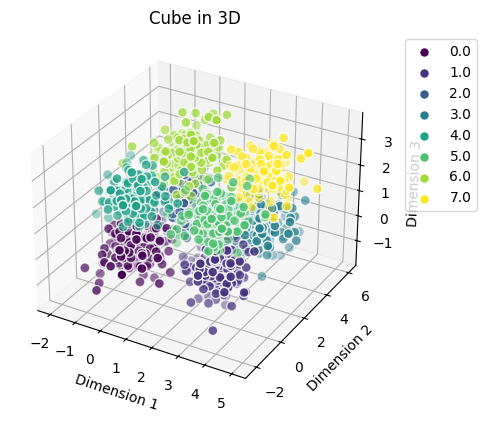

In [149]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
unique_colors = np.unique(cube[:, 3])
colors = plt.cm.get_cmap('viridis', len(unique_colors))

for i, color in enumerate(unique_colors):
    mask = cube[:, 3] == color
    ax.scatter(cube[mask, 0], cube[mask, 1], cube[mask, 2], color=colors(i), edgecolors='w', s=50, label=f'{color}')

ax.set_title('Cube in 3D')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [150]:
data_hex = pd.read_csv('../data/hexagon.csv').values[:, :2]
data_cube = pd.read_csv('../data/cube.csv').values[:, :3]

In [151]:
labels_hex = pd.read_csv('../data/hexagon.csv').values[:, -1]
labels_cube = pd.read_csv('../data/cube.csv').values[:, -1]

## Unikalne klasy w danych

In [152]:
unique_labels = np.unique(labels_cube)
print(unique_labels)


[0. 1. 2. 3. 4. 5. 6. 7.]


## Testowanie sieci z gaussowską funkcją sąsiedztwa 

### Modyfikowanie parametrem sigma

In [153]:
#Best parameters: {'sigma': 1.0, 'lr': 0.2, 'decay': 0.99, 'sigma_decay': 0.95}

In [154]:
network_a = KohonenNetwork(M=5, N=5, input_dim=3, initial_sigma=1.0, sigma_decay=0.95, init_lr=0.2, decay_rate=0.99)

In [155]:
network_a.train(data_cube, 50)

In [156]:
network_a.assign_clusters(data_cube)

Network parameters: M=5, N=5


/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_33193/2042717049.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


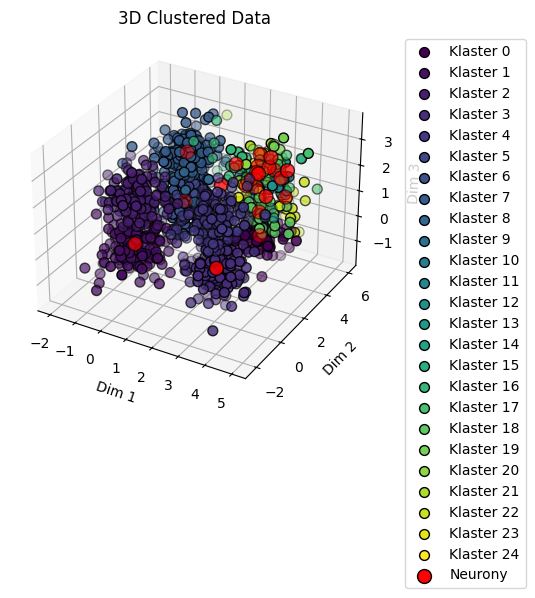

In [157]:
network_a.display_clustered_data(data_cube)

# network_a = KohonenNetwork(M=5, N=5, input_dim=3, initial_sigma=1.0, sigma_decay=0.95, init_lr=0.2, decay_rate=0.99)
# 0.804777830236087

In [158]:
predicted_labels = np.array([network_a.bmu_cluster_map[network_a._find_bmu_and_update_weights(sample, None, None)] for sample in data_cube])

In [112]:
v_measure_a = v_measure_score(labels_cube, predicted_labels)

In [113]:
v_measure_a

0.804777830236087

In [1]:
# # Define the range of parameters for the grid search
# sigma_values = [0.1, 0.2, 0.5, 1.0, 1.5, 2.0]
# learning_rates = [0.05, 0.1, 0.2, 0.3, 0.5, 1]
# decay_rates = [0.1, 0.5, 0.99, 1]
# sigma_decays = [0.95, 0.99, 1]  # Adjusting how quickly the neighborhood function shrinks

# # Initialize variables to store the best score and corresponding parameters
# best_v_score = 0
# best_params = {}

# # Assume 'data_cube' and 'labels_cube' are already defined as your data and true labels
# for sigma in sigma_values:
#     for lr in learning_rates:
#         for decay in decay_rates:
#             for sigma_decay in sigma_decays:
#                 # Create a new Kohonen network instance with the current set of parameters
#                 network = KohonenNetwork(M=5, N=5, input_dim=3, initial_sigma=sigma, sigma_decay=sigma_decay, init_lr=lr, decay_rate=decay, neighborhood_function='mexican_hat')
                
#                 # Train the network
#                 network.train(data_cube, 50)
                
#                 # Assign clusters based on the trained network
#                 network.assign_clusters(data_cube)
                
#                 # Calculate predicted labels
#                 predicted_labels = np.array([
#                     network.bmu_cluster_map[network._find_bmu_and_update_weights(sample, None, None)]
#                     for sample in data_cube
#                 ])
                
#                 # Calculate the V-score for the current configuration
#                 v_measure = v_measure_score(labels_cube, predicted_labels)
                
#                 # Print the current results (optional, for tracking progress)
#                 print(f"Sigma: {sigma}, LR: {lr}, Decay: {decay}, Sigma Decay: {sigma_decay}, V-score: {v_measure}")
                
#                 # Check if the current V-score is the best one, and if so, update the best parameters
#                 if v_measure > best_v_score:
#                     best_v_score = v_measure
#                     best_params = {'sigma': sigma, 'lr': lr, 'decay': decay, 'sigma_decay': sigma_decay}

# # Print the best parameters and corresponding V-score after the grid search completes
# print("Best V-score:", best_v_score)
# print("Best parameters:", best_params)

In [114]:
network_b = KohonenNetwork(M=5, N=5, input_dim=3, initial_sigma=0.5, sigma_decay=0.95, init_lr=0.20, decay_rate=0.99)

In [115]:
network_b.train(data_cube, 10)

In [116]:
network_b.assign_clusters(data_cube)

/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_33193/2265204966.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


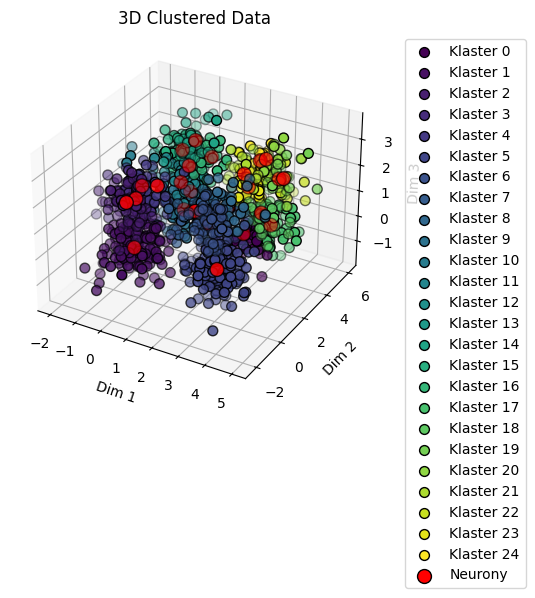

In [117]:
network_b.display_clustered_data(data_cube)

# network_b = KohonenNetwork(M=5, N=5, input_dim=3, initial_sigma=0.5, sigma_decay=0.95, init_lr=0.2, decay_rate=0.99)
# 0.7480154936752501

In [118]:
predicted_labels = np.array([network_b.bmu_cluster_map[network_b._find_bmu_and_update_weights(sample, None, None)] for sample in data_cube])

In [119]:
v_measure_b = v_measure_score(labels_cube, predicted_labels)

In [120]:
v_measure_b

0.7480154936752501

In [121]:
network_c = KohonenNetwork(M=5, N=5, input_dim=3, initial_sigma=0.1, sigma_decay=0.95, init_lr=0.20, decay_rate=0.99)

In [122]:
network_c.train(data_cube, 10)

In [123]:
network_c.assign_clusters(data_cube)

/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_33193/2265204966.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


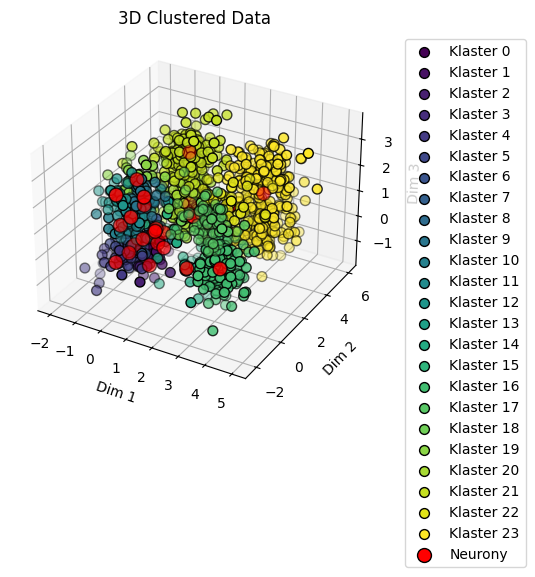

In [124]:
network_c.display_clustered_data(data_cube)

# network_c = KohonenNetwork(M=5, N=5, input_dim=3, initial_sigma=0.1, sigma_decay=0.95, init_lr=0.2, decay_rate=0.99)
# 0.7580449481964096

In [125]:
predicted_labels = np.array([network_c.bmu_cluster_map[network_c._find_bmu_and_update_weights(sample, None, None)] for sample in data_cube])

In [126]:
v_measure_c = v_measure_score(labels_cube, predicted_labels)

In [127]:
v_measure_c

0.7580449481964096

### Sprawdzenie dla małego iloczynu MxN

In [128]:
network2 = KohonenNetwork(M=2, N=2, input_dim=3, initial_sigma=1.0, sigma_decay=0.1, init_lr=2, decay_rate=100)


In [129]:
network2.train(data_cube,  10)

In [130]:
network2.assign_clusters(data_cube)

/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_33193/2265204966.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


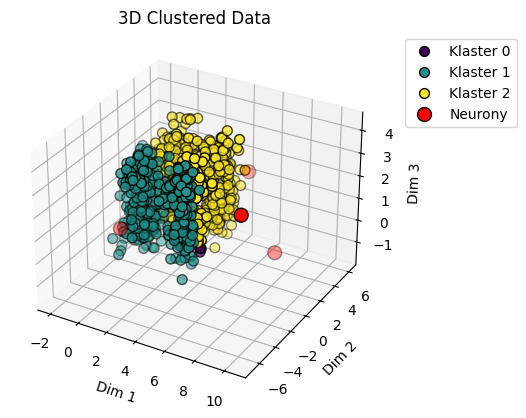

In [131]:
network2.display_clustered_data(data_cube)

# network2 = KohonenNetwork(M=2, N=2, input_dim=3, initial_sigma=1.0, sigma_decay=0.1, init_lr=2, decay_rate=100)
# 0.38402982246955025

In [132]:
predicted_labels = np.array([network2.bmu_cluster_map[network2._find_bmu_and_update_weights(sample, None, None)] for sample in data_cube])

In [133]:
v_measure_2 = v_measure_score(labels_cube, predicted_labels)

In [134]:
v_measure_2

0.38402982246955025

## Testowanie sieci z funkcją sąsiedztwa minus druga pochodną funkcji gaussowskiej

### Modyfikowanie parametrem sigma

In [ ]:
# Best parameters: {'sigma': 0.5, 'lr': 0.2, 'decay': 0.99, 'sigma_decay': 1}

In [185]:
network_a = KohonenNetwork(M=5, N=5, input_dim=3, initial_sigma=1, sigma_decay=1, init_lr=0.2, decay_rate=0.99, neighborhood_function='mexican_hat')

In [186]:
network_a.train(data_cube, 50)

In [187]:
network_a.assign_clusters(data_cube)

Network parameters: M=5, N=5


/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_33193/3064465913.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


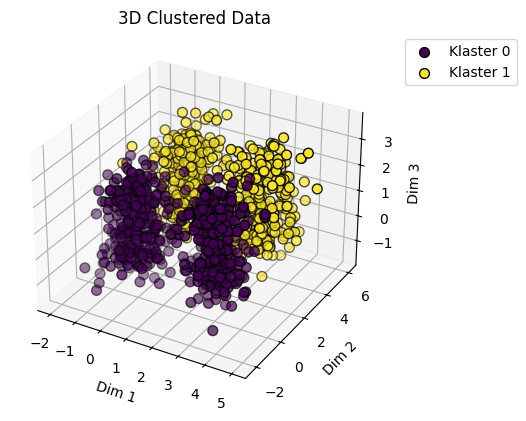

In [188]:
network_a.display_clustered_data(data_cube, neuron_positions=False)

# network_a = KohonenNetwork(M=5, N=5, input_dim=3, initial_sigma=1, sigma_decay=1, init_lr=0.2, decay_rate=0.99, neighborhood_function='mexican_hat')
# 0.5

Network parameters: M=5, N=5


/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_33193/3064465913.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


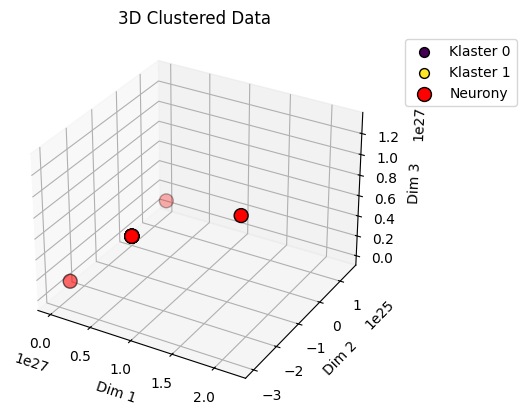

In [189]:
network_a.display_clustered_data(data_cube, neuron_positions=True)

# network_a = KohonenNetwork(M=5, N=5, input_dim=3, initial_sigma=1, sigma_decay=1, init_lr=0.2, decay_rate=0.99, neighborhood_function='mexican_hat')
# 0.5

In [164]:
predicted_labels = np.array([network_a.bmu_cluster_map[network_a._find_bmu_and_update_weights(sample, None, None)] for sample in data_cube])

In [165]:
v_measure_a = v_measure_score(labels_cube, predicted_labels)

In [166]:
v_measure_a

0.5

In [167]:
# Define the range of parameters for the grid search
sigma_values = [0.1, 0.2, 0.5, 1.0, 1.5, 2.0]
learning_rates = [0.05, 0.1, 0.2, 0.3, 0.5, 1]
decay_rates = [0.1, 0.5, 0.99, 1]
sigma_decays = [0.95, 0.99, 1]  # Adjusting how quickly the neighborhood function shrinks

# Initialize variables to store the best score and corresponding parameters
best_v_score = 0
best_params = {}

# Assume 'data_cube' and 'labels_cube' are already defined as your data and true labels
for sigma in sigma_values:
    for lr in learning_rates:
        for decay in decay_rates:
            for sigma_decay in sigma_decays:
                # Create a new Kohonen network instance with the current set of parameters
                network = KohonenNetwork(M=5, N=5, input_dim=3, initial_sigma=sigma, sigma_decay=sigma_decay, init_lr=lr, decay_rate=decay, neighborhood_function='mexican_hat')
                
                # Train the network
                network.train(data_cube, 50)
                
                # Assign clusters based on the trained network
                network.assign_clusters(data_cube)
                
                # Calculate predicted labels
                predicted_labels = np.array([
                    network.bmu_cluster_map[network._find_bmu_and_update_weights(sample, None, None)]
                    for sample in data_cube
                ])
                
                # Calculate the V-score for the current configuration
                v_measure = v_measure_score(labels_cube, predicted_labels)
                
                # Print the current results (optional, for tracking progress)
                print(f"Sigma: {sigma}, LR: {lr}, Decay: {decay}, Sigma Decay: {sigma_decay}, V-score: {v_measure}")
                
                # Check if the current V-score is the best one, and if so, update the best parameters
                if v_measure > best_v_score:
                    best_v_score = v_measure
                    best_params = {'sigma': sigma, 'lr': lr, 'decay': decay, 'sigma_decay': sigma_decay}

# Print the best parameters and corresponding V-score after the grid search completes
print("Best V-score:", best_v_score)
print("Best parameters:", best_params)

In [190]:
network_b = KohonenNetwork(M=5, N=5, input_dim=3, initial_sigma=0.5, sigma_decay=1, init_lr=0.2, decay_rate=0.99, neighborhood_function='mexican_hat')

In [191]:
network_b.train(data_cube, 50)

In [192]:
network_b.assign_clusters(data_cube)

Network parameters: M=5, N=5


/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_33193/3064465913.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


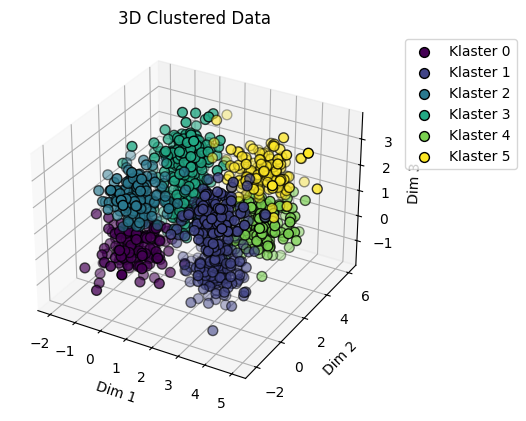

In [193]:
network_b.display_clustered_data(data_cube, neuron_positions=False)

# network_b = KohonenNetwork(M=5, N=5, input_dim=3, initial_sigma=0.5, sigma_decay=1, init_lr=0.2, decay_rate=0.99, neighborhood_function='mexican_hat')
# 0.836219391930018

In [194]:
predicted_labels = np.array([network_b.bmu_cluster_map[network_b._find_bmu_and_update_weights(sample, None, None)] for sample in data_cube])

In [195]:
v_measure_b = v_measure_score(labels_cube, predicted_labels)

In [196]:
v_measure_b

0.836219391930018

In [199]:
network_c = KohonenNetwork(M=5, N=5, input_dim=3, initial_sigma=0.1, sigma_decay=1, init_lr=0.2, decay_rate=0.99, neighborhood_function='mexican_hat')

In [200]:
network_c.train(data_cube, 50)

In [201]:
network_c.assign_clusters(data_cube)

Network parameters: M=5, N=5


/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_33193/3064465913.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


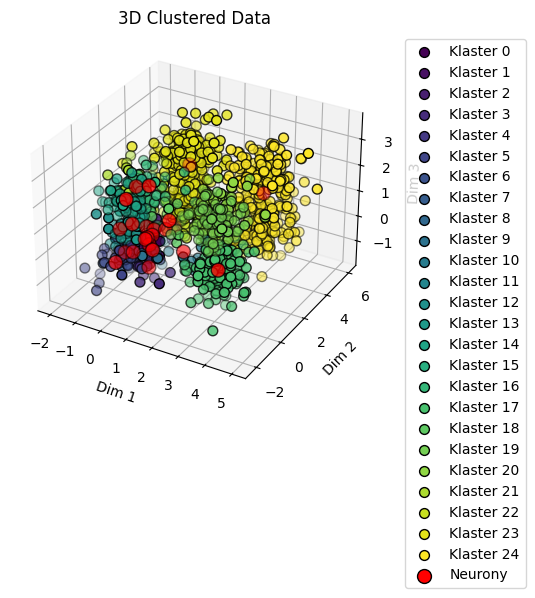

In [202]:
network_c.display_clustered_data(data_cube)

# network_c = KohonenNetwork(M=5, N=5, input_dim=3, initial_sigma=0.1, sigma_decay=1, init_lr=0.2, decay_rate=0.99, neighborhood_function='mexican_hat')
# 0.7329774760888719

In [203]:
predicted_labels = np.array([network_c.bmu_cluster_map[network_c._find_bmu_and_update_weights(sample, None, None)] for sample in data_cube])

In [204]:
v_measure_c = v_measure_score(labels_cube, predicted_labels)

In [205]:
v_measure_c

0.7329774760888719

### Sprawdzenie dla małego iloczynu MxN

In [ ]:
network2 = KohonenNetwork(M=2, N=2, input_dim=3, initial_sigma=1.0, sigma_decay=0.1, init_lr=2, decay_rate=100, neighborhood_function='mexican_hat')


In [ ]:
network2.train(data_cube,  10)

In [ ]:
network2.assign_clusters(data_cube)

/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_33193/2265204966.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


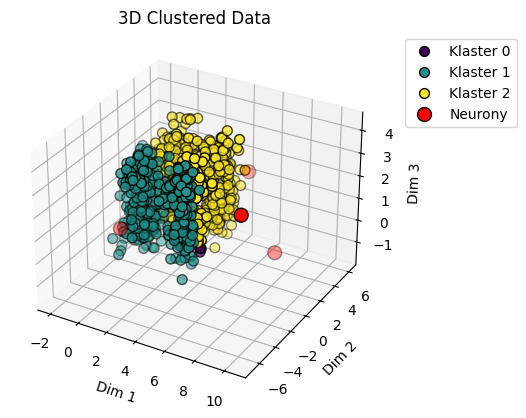

In [ ]:
network2.display_clustered_data(data_cube)

# network2 = KohonenNetwork(M=2, N=2, input_dim=3, initial_sigma=1.0, sigma_decay=0.1, init_lr=2, decay_rate=100)
# 0.38402982246955025

In [ ]:
predicted_labels = np.array([network2.bmu_cluster_map[network2._find_bmu_and_update_weights(sample, None, None)] for sample in data_cube])

In [ ]:
v_measure_2 = v_measure_score(labels_cube, predicted_labels)

In [ ]:
v_measure_2

0.38402982246955025

In [235]:
network_a = KohonenNetwork(M=3, N=1, input_dim=3, initial_sigma=1.0, sigma_decay=0.95, init_lr=0.2, decay_rate=0.99)

In [236]:
network_a.train(data_cube, 50)

In [237]:
network_a.assign_clusters(data_cube)

Network parameters: M=3, N=1


/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_33193/3064465913.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


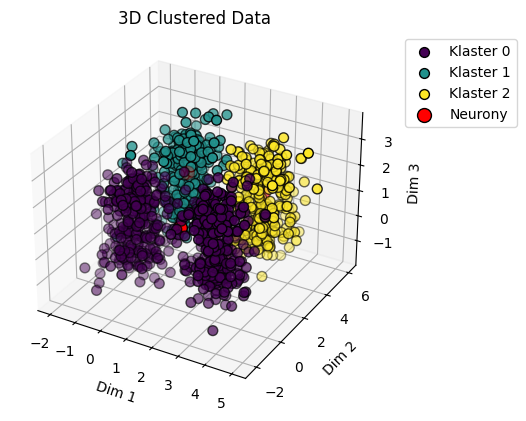

In [238]:
network_a.display_clustered_data(data_cube)

# network_a = KohonenNetwork(M=3, N=1, input_dim=3, initial_sigma=1.0, sigma_decay=0.95, init_lr=0.2, decay_rate=0.99)
# 0.6543219280319652

In [239]:
predicted_labels = np.array([network_a.bmu_cluster_map[network_a._find_bmu_and_update_weights(sample, None, None)] for sample in data_cube])

In [240]:
v_measure_a = v_measure_score(labels_cube, predicted_labels)

In [241]:
v_measure_a

0.6543219280319652

In [242]:
network_a = KohonenNetwork(M=4, N=2, input_dim=3, initial_sigma=1.0, sigma_decay=0.95, init_lr=0.2, decay_rate=0.99)

In [243]:
network_a.train(data_cube, 50)

In [244]:
network_a.assign_clusters(data_cube)

Network parameters: M=4, N=2


/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_33193/3064465913.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


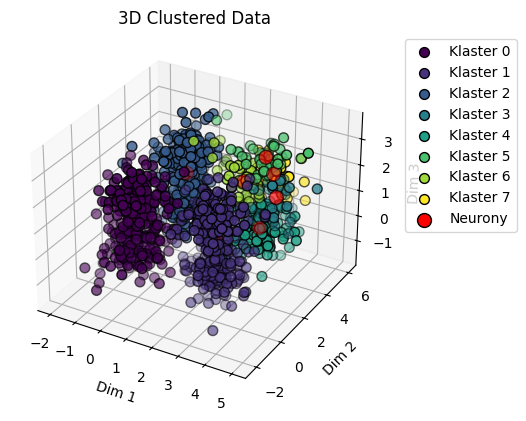

In [245]:
network_a.display_clustered_data(data_cube)

# network_a = KohonenNetwork(M=4, N=2, input_dim=3, initial_sigma=1.0, sigma_decay=0.95, init_lr=0.2, decay_rate=0.99)
# 0.7568525228425642

In [246]:
predicted_labels = np.array([network_a.bmu_cluster_map[network_a._find_bmu_and_update_weights(sample, None, None)] for sample in data_cube])

In [247]:
v_measure_a = v_measure_score(labels_cube, predicted_labels)

In [248]:
v_measure_a

0.7568525228425642

In [256]:
network_a = KohonenNetwork(M=6, N=6, input_dim=3, initial_sigma=1.0, sigma_decay=0.95, init_lr=0.2, decay_rate=0.99)

In [257]:
network_a.train(data_cube, 50)

In [258]:
network_a.assign_clusters(data_cube)

/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_33193/3064465913.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(distinct_clusters))


Network parameters: M=6, N=6


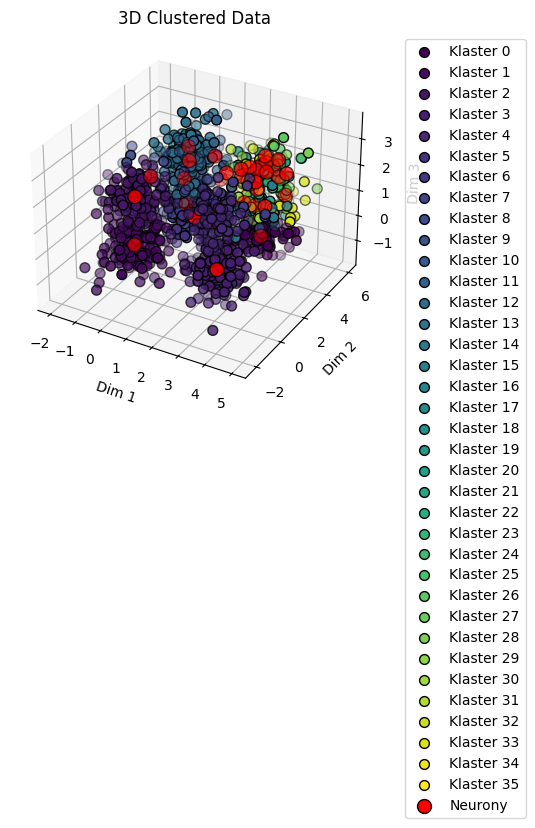

In [259]:
network_a.display_clustered_data(data_cube)

# network_a = KohonenNetwork(M=6, N=6, input_dim=3, initial_sigma=1.0, sigma_decay=0.95, init_lr=0.2, decay_rate=0.99)
# 0.766638293048057

In [260]:
predicted_labels = np.array([network_a.bmu_cluster_map[network_a._find_bmu_and_update_weights(sample, None, None)] for sample in data_cube])

In [261]:
v_measure_a = v_measure_score(labels_cube, predicted_labels)

In [262]:
v_measure_a

0.766638293048057